<a href="https://colab.research.google.com/github/vasudeywos/PII_labels_DPO/blob/main/merged_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets trl scikit-learn tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print "Tesla T4"

True
Tesla T4


In [ ]:
!pip uninstall -y bitsandbytes
!pip install bitsandbytes

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PII_dataset_2.xlsx to PII_dataset_2.xlsx


##SFT

In [ ]:
import os
os.environ['WANDB_DISABLED'] = "true"

import pandas as pd
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

def format_chat_prompt(user_input):
    user_prompt = f"<|im_start|>user\n{user_input}<|im_end|>\n"
    assistant_prompt = "<|im_start|>assistant\n"
    return user_prompt + assistant_prompt
df = pd.read_excel('PII_dataset_2.xlsx')

def prepare_sft_text(row):
    language = row['language_code']
    label = row['pruned_label']
    is_sensitive = row['is_sensitive']
    prompt = format_chat_prompt(f"Is this label sensitive in {language}? {label}")
    response = "yes<|im_end|>" if is_sensitive == 1 else "no<|im_end|>"
    text = prompt + response
    return text

sft_data = []
for _, row in df.iterrows():
    sft_data.append({
        'text': prepare_sft_text(row)
    })

sft_dataset = Dataset.from_list(sft_data)
sft_split_dataset = sft_dataset.train_test_split(test_size=0.1)
sft_train_dataset = sft_split_dataset['train']
sft_eval_dataset = sft_split_dataset['test']

compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

model_name ="Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
base_model = prepare_model_for_kbit_training(base_model)

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, peft_config)

sft_training_args = SFTConfig(
    output_dir="sft_checkpoint",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=10,
    eval_steps=50,
    save_strategy="epoch",
    report_to="none",
)

sft_trainer = SFTTrainer(
    model=model,
    train_dataset=sft_train_dataset,
    eval_dataset=sft_eval_dataset,
    peft_config=peft_config,
    args=sft_training_args,
)

sft_trainer.train()
sft_trainer.save_model("sft_checkpoint")

average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


Adding EOS to train dataset:   0%|          | 0/5400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5400 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,6.808700
20,5.116200
30,3.640700
40,2.360200
50,2.192900
60,2.022400
70,1.862000
80,1.736200
90,1.927700
100,1.816100


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant p

In [ ]:
!zip -r sft_checkpoint.zip sft_checkpoint

  adding: sft_checkpoint/ (stored 0%)
  adding: sft_checkpoint/vocab.json (deflated 61%)
  adding: sft_checkpoint/special_tokens_map.json (deflated 69%)
  adding: sft_checkpoint/merges.txt (deflated 57%)
  adding: sft_checkpoint/tokenizer_config.json (deflated 89%)
  adding: sft_checkpoint/tokenizer.json (deflated 81%)
  adding: sft_checkpoint/checkpoint-8100/ (stored 0%)
  adding: sft_checkpoint/checkpoint-8100/vocab.json (deflated 61%)
  adding: sft_checkpoint/checkpoint-8100/special_tokens_map.json (deflated 69%)
  adding: sft_checkpoint/checkpoint-8100/merges.txt (deflated 57%)
  adding: sft_checkpoint/checkpoint-8100/tokenizer_config.json (deflated 89%)
  adding: sft_checkpoint/checkpoint-8100/scheduler.pt (deflated 56%)
  adding: sft_checkpoint/checkpoint-8100/tokenizer.json (deflated 81%)
  adding: sft_checkpoint/checkpoint-8100/optimizer.pt (deflated 12%)
  adding: sft_checkpoint/checkpoint-8100/adapter_config.json (deflated 54%)
  adding: sft_checkpoint/checkpoint-8100/trainer

In [ ]:
from google.colab import files
files.download('sft_checkpoint.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##DPO

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from trl import DPOConfig, DPOTrainer
from peft import AutoPeftModelForCausalLM
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def format_chat_prompt(user_input):
    user_prompt = f"<|im_start|>user\n{user_input}<|im_end|>\n"
    assistant_prompt = "<|im_start|>assistant\n"
    return user_prompt + assistant_prompt

df = pd.read_excel('PII_dataset_2.xlsx')

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

data = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Building DPO Dataset"):
    language = row['language_code']
    label = row['pruned_label']
    is_sensitive = row['is_sensitive']

    user_input = f"Is this label sensitive in {language}? {label}"
    prompt = format_chat_prompt(user_input)

    chosen = f"yes<|im_end|>" if is_sensitive == 1 else f"no<|im_end|>"
    rejected = f"no<|im_end|>" if is_sensitive == 1 else f"yes<|im_end|>"

    data.append({'prompt': prompt, 'chosen': chosen, 'rejected': rejected, 'is_sensitive': is_sensitive})

dataset = Dataset.from_list(data)
split_dataset = dataset.train_test_split(test_size=0.1)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

sft_checkpoint_path = "/content/drive/MyDrive/sft_checkpoint"

sft_model = AutoPeftModelForCausalLM.from_pretrained(
    sft_checkpoint_path,
    device_map="auto",
    torch_dtype=torch.float16,
    is_trainable=True
)
sft_ref_model = AutoPeftModelForCausalLM.from_pretrained(
    sft_checkpoint_path,
    device_map="auto",
    torch_dtype=torch.float16
)


ft_model_name = "/content/drive/MyDrive/Qwen2.5-3.5B-DPO-QLoRA"

training_args = DPOConfig(
    output_dir=ft_model_name,
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    save_strategy="epoch",
    eval_steps=50,
    report_to="none",
    optim="paged_adamw_8bit",
)

trainer = DPOTrainer(
    model=sft_model,
    ref_model=sft_ref_model,
    args=training_args,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,

)


trainer.train()

trainer.save_model(ft_model_name)


Building DPO Dataset: 100%|██████████| 6000/6000 [00:00<00:00, 12202.48it/s]


Extracting prompt in train dataset:   0%|          | 0/5400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/5400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5400 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.693900
20,0.695400
30,0.689700
40,0.683900
50,0.687200
60,0.675500
70,0.681900
80,0.667900
90,0.649300
100,0.615100


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from trl import DPOConfig, DPOTrainer
from peft import AutoPeftModelForCausalLM
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def format_chat_prompt(user_input):
    user_prompt = f"<|im_start|>user\n{user_input}<|im_end|>\n"
    assistant_prompt = "<|im_start|>assistant\n"
    return user_prompt + assistant_prompt

df = pd.read_excel('PII_dataset_2.xlsx')

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

data = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Building DPO Dataset"):
    language = row['language_code']
    label = row['pruned_label']
    is_sensitive = row['is_sensitive']

    user_input = f"Is this label sensitive in {language}? {label}"
    prompt = format_chat_prompt(user_input)

    chosen = f"yes<|im_end|>" if is_sensitive == 1 else f"no<|im_end|>"
    rejected = f"no<|im_end|>" if is_sensitive == 1 else f"yes<|im_end|>"

    data.append({'prompt': prompt, 'chosen': chosen, 'rejected': rejected, 'is_sensitive': is_sensitive})

dataset = Dataset.from_list(data)
split_dataset = dataset.train_test_split(test_size=0.1)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

def classify_prompts(generator, prompts):
    predictions = []
    for prompt in prompts:
        output = generator(
            prompt,
            max_new_tokens=10,
            truncation=True,
            num_return_sequences=1,
            do_sample=False
        )
        answer = output[0]['generated_text'].lower()
        pred = 1 if "yes" in answer else 0
        predictions.append(pred)
    return np.array(predictions)

def display_metrics(title, accuracy, precision, recall, f1):
    print(f"\n\033[1m{title}:\033[0m")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

dpo_checkpoint_path = "/content/drive/MyDrive/Qwen2.5-3B-DPO-QLoRA"
sft_checkpoint_path = "/content/drive/MyDrive/sft_checkpoint"

dpo_model = AutoPeftModelForCausalLM.from_pretrained(
    dpo_checkpoint_path,
    device_map="auto",
    torch_dtype=torch.float16
)
dpo_generator = pipeline("text-generation", model=dpo_model, tokenizer=tokenizer, device_map="auto")

sft_model_eval = AutoPeftModelForCausalLM.from_pretrained(
    sft_checkpoint_path,
    device_map="auto",
    torch_dtype=torch.float16
)
sft_generator = pipeline("text-generation", model=sft_model_eval, tokenizer=tokenizer, device_map="auto")

compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)
original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
original_generator = pipeline("text-generation", model=original_model, tokenizer=tokenizer, device_map="auto")

prompts = eval_dataset['prompt']
true_labels = np.array(eval_dataset['is_sensitive'])

original_predictions = classify_prompts(original_generator, prompts)
sft_predictions = classify_prompts(sft_generator, prompts)
dpo_predictions = classify_prompts(dpo_generator, prompts)

import csv

original_accuracy = accuracy_score(true_labels, original_predictions)
original_precision = precision_score(true_labels, original_predictions)
original_recall = recall_score(true_labels, original_predictions)
original_f1 = f1_score(true_labels, original_predictions)

sft_accuracy = accuracy_score(true_labels, sft_predictions)
sft_precision = precision_score(true_labels, sft_predictions)
sft_recall = recall_score(true_labels, sft_predictions)
sft_f1 = f1_score(true_labels, sft_predictions)

dpo_accuracy = accuracy_score(true_labels, dpo_predictions)
dpo_precision = precision_score(true_labels, dpo_predictions)
dpo_recall = recall_score(true_labels, dpo_predictions)
dpo_f1 = f1_score(true_labels, dpo_predictions)

with open('/content/drive/MyDrive/model_metrics.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    writer.writerow(['Original Model', original_accuracy, original_precision, original_recall, original_f1])
    writer.writerow(['SFT Model', sft_accuracy, sft_precision, sft_recall, sft_f1])
    writer.writerow(['DPO Model', dpo_accuracy, dpo_precision, dpo_recall, dpo_f1])

print("Metrics have been saved to /content/drive/MyDrive/model_metrics.csv")

display_metrics("Original Model",
                accuracy_score(true_labels, original_predictions),
                precision_score(true_labels, original_predictions),
                recall_score(true_labels, original_predictions),
                f1_score(true_labels, original_predictions))

display_metrics("SFT Model",
                accuracy_score(true_labels, sft_predictions),
                precision_score(true_labels, sft_predictions),
                recall_score(true_labels, sft_predictions),
                f1_score(true_labels, sft_predictions))

display_metrics("DPO Model",
                accuracy_score(true_labels, dpo_predictions),
                precision_score(true_labels, dpo_predictions),
                recall_score(true_labels, dpo_predictions),
                f1_score(true_labels, dpo_predictions))

def classify_label(label, language):
    prompt = format_chat_prompt(f"Is this label sensitive in {language}? {label}")
    output = dpo_generator(
        prompt,
        max_new_tokens=10,
        truncation=True,
        num_return_sequences=1,
        do_sample=False
    )
    answer = output[0]['generated_text'].lower()
    return "Sensitive" if "yes" in answer else "Not Sensitive"

print("\n🔍 Example Inference:")
print("Label: 'personal_email', Language: 'en' →", classify_label("personal_email", "en"))

Building DPO Dataset: 100%|██████████| 6000/6000 [00:00<00:00, 11041.82it/s]
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p'

Metrics have been saved to /content/drive/MyDrive/model_metrics.csv

Original Model:
Accuracy : 0.5067
Precision: 0.5011
Recall   : 0.7778
F1 Score : 0.6095

SFT Model:
Accuracy : 0.7050
Precision: 0.6351
Recall   : 0.9495
F1 Score : 0.7611

DPO Model:
Accuracy : 0.9000
Precision: 0.8911
Recall   : 0.9091
F1 Score : 0.9000

🔍 Example Inference:
Label: 'personal_email', Language: 'en' → Sensitive


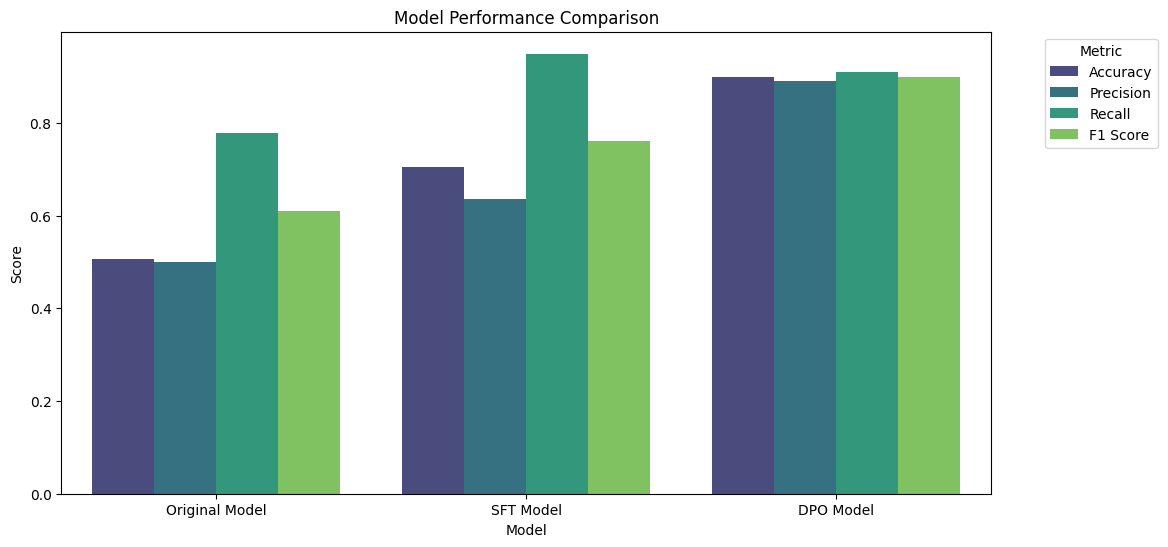

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/model_metrics.csv')


df_melted = df.melt(id_vars=['Model'], var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted, palette='viridis')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()